In [17]:
from dataset_loader import load_dataset
from utils import *

import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from metric_learn import ITML, SDML

import os

In [70]:
def generate_semantic_pairs(dataset, num_pairs, num_closest):
    random_pairs = []
    y = []
    
    for _ in range(num_pairs):
        # Choose one random index for the first element of the pair
        idx1 = random.choice(range(len(dataset)))
        
        # Calculate distances from dataset[idx1] to all other vectors
        distances = vectorized_cosine_distances_normalized(dataset[idx1], dataset)

        # Get the indices of the closest num_closest vectors (excluding idx1)
        closest_indices = np.argsort(distances)[:num_closest + 1]  # +1 to include idx1 itself
        closest_indices = [idx for idx in closest_indices if idx != idx1]  # Exclude idx1
        
        # Ensure there are enough closest indices
        if len(closest_indices) < 1:
            raise ValueError("Not enough distinct vectors in the dataset to form pairs.")
        
        # Choose one index for the similar 
        idx2 = random.choice(closest_indices[:15])
        
        # Choose one index for the dissimilar
        idx3 = random.choice(closest_indices[15:30])
        
        pair1 = [dataset[idx1], dataset[idx2]]
        pair2 = [dataset[idx1], dataset[idx3]]
        
        random_pairs.append(pair1)
        random_pairs.append(pair2)
        
        y.append(1)   # Positive pair
        y.append(-1)  # Negative pair
        
    return random_pairs, y

In [3]:
def run_itml_experiment(prior_matrix, pairs, labels):
    # Train ITML model
    itml_model = ITML(gamma=1, max_iter=1000, prior=prior_matrix)
    itml_model.fit(pairs, labels)

    # Get Mahalanobis matrix and calculate results
    mahalanobis_matrix = itml_model.get_mahalanobis_matrix()
    eigenvalues = np.linalg.eigvals(mahalanobis_matrix)
    lambda_min = np.min(eigenvalues).real
    scaling_factor = calculate_scaling_factor(mahalanobis_matrix).real
    print("ITML SF je: ", scaling_factor)

    # Store the results in a dictionary
    result = {
        'Num of Inputs': len(pairs) / 2,  # Count each experiment as one input
        'Lambda': format(lambda_min, '.6f'),
        'Scaling Factor': format(scaling_factor, '.6f')
    }

    return result, mahalanobis_matrix


def run_sdml_experiment(prior_matrix, pairs, labels):
    # Train ITML model
    model = SDML(balance_param=0.5, sparsity_param=0.01, prior=prior_matrix)
    model.fit(pairs, labels)

    # Get Mahalanobis matrix and calculate results
    mahalanobis_matrix = model.get_mahalanobis_matrix()
    eigenvalues = np.linalg.eigvals(mahalanobis_matrix)
    lambda_min = np.min(eigenvalues).real
    scaling_factor = calculate_scaling_factor(mahalanobis_matrix).real
    print(f"SF je {scaling_factor}")

    # Store the results in a dictionary
    result = {
        'Num of Inputs': len(pairs) / 2,  # Count each experiment as one input
        'Lambda': format(lambda_min, '.6f'),
        'Scaling Factor': format(scaling_factor, '.6f')
    }

    return result, mahalanobis_matrix

In [4]:
# Specify the directory you want to read from
directory = os.path.join(os.path.dirname(os.getcwd()), 'ViT-L14')

# size = 252001
files_set_4 = [
    '003.txt', '004.txt', '005.txt', 
    '006.txt', '007.txt', '048.txt',
    '049.txt', '055.txt', '056.txt',
    '057.txt'
]

In [5]:
image_names, dataset = load_dataset(directory, files_set_4)

Processing file: 003.txt
	Number of vectors: 5516
Processing file: 004.txt
	Number of vectors: 8386
Processing file: 005.txt
	Number of vectors: 13638
Processing file: 006.txt
	Number of vectors: 17044
Processing file: 007.txt
	Number of vectors: 15181
Processing file: 048.txt
	Number of vectors: 26687
Processing file: 049.txt
	Number of vectors: 44032
Processing file: 055.txt
	Number of vectors: 43070
Processing file: 056.txt
	Number of vectors: 39764
Processing file: 057.txt
	Number of vectors: 38683

Number of vectors in all files: 252001
Number of dimensions: 768


In [13]:
dataset = np.array(dataset)

In [95]:
results_1 = pd.DataFrame(columns=['Num of Inputs', 'Lambda', 'Scaling Factor', 'Experiment Type'])
initial_prior_matrix = np.eye(len(dataset[0]))

In [96]:
generated_pairs, labels = generate_random_pairs(dataset, 200)

In [ ]:
initial_subset_size = 10

for i in range(1, 21):
    # Calculate the number of pairs to use in this iteration
    num_pairs = initial_subset_size * i * 2

    # Take a subset of the generated pairs and labels
    pairs_subset = generated_pairs[:num_pairs]
    labels_subset = labels[:num_pairs]
    
    # Run the experiment
    result, _ = run_itml_experiment(initial_prior_matrix, pairs_subset, labels_subset)

    # Add the experiment type and other metadata
    result['Experiment Type'] = 'ITML Single batch (Random Inputs)'

    # Append the result to the DataFrame
    results_1 = results_1.append(result, ignore_index=True)

In [ ]:
initial_subset_size = 10

for i in range(1, 21):
    # Calculate the number of pairs to use in this iteration
    num_pairs = initial_subset_size * i * 2

    # Take a subset of the generated pairs and labels
    pairs_subset = generated_pairs[:num_pairs]
    labels_subset = labels[:num_pairs]
    
    # Run the experiment
    result, _ = run_sdml_experiment(initial_prior_matrix, pairs_subset, labels_subset)

    # Add the experiment type and other metadata
    result['Experiment Type'] = 'SDML Single batch (Random Inputs)'

    # Append the result to the DataFrame
    results_1 = results_1.append(result, ignore_index=True)

NOTE: During the experiments, we frequently encountered issues where the SDML method failed to converge when using randomly generated training data, that it can not find a PSD matrix.

In [48]:
results_1.to_pickle('exp_3_random_data_generation_results.pkl')

## If you want to only show previous results, start from here

In [104]:
results_1 = pd.read_pickle('exp_3_random_data_generation_results.pkl')

In [105]:
results_1

,Num of Inputs,Lambda,Scaling Factor,Experiment Type
0,10.0,0.918589,1.043372,SDML Single batch (Random Inputs)
1,20.0,0.842632,1.089384,SDML Single batch (Random Inputs)
2,30.0,0.758680,1.148076,SDML Single batch (Random Inputs)
3,40.0,0.712519,1.184682,SDML Single batch (Random Inputs)
4,50.0,0.681850,1.211032,SDML Single batch (Random Inputs)
5,60.0,0.608493,1.281953,SDML Single batch (Random Inputs)
6,70.0,0.595885,1.295445,SDML Single batch (Random Inputs)
7,80.0,0.582459,1.310289,SDML Single batch (Random Inputs)
8,90.0,0.516895,1.390909,SDML Single batch (Random Inputs)
9,90.0,0.516895,1.390909,SDML Single batch (Random Inputs)


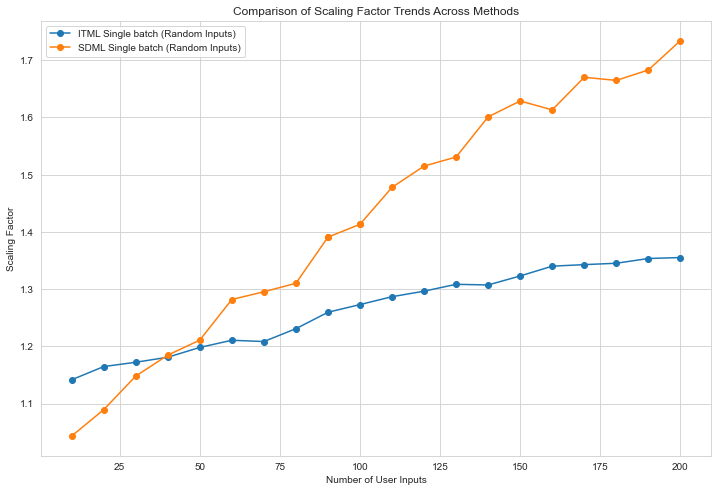

In [106]:
results_1['Scaling Factor'] = pd.to_numeric(results_1['Scaling Factor'])

# Plotting the scaling factor comparison
plt.figure(figsize=(12, 8))

# Group the results by 'Experiment Type' and plot them
for experiment_type, group_data in results_1.groupby('Experiment Type'):
    plt.plot(group_data['Num of Inputs'], group_data['Scaling Factor'], label=experiment_type, marker='o')

# Add labels and legend to the plot
plt.xlabel('Number of User Inputs')
plt.ylabel('Scaling Factor')
plt.title('Comparison of Scaling Factor Trends Across Methods')
plt.legend()
plt.grid(True)
plt.show()

---

In [71]:
results = pd.DataFrame(columns=['Num of Inputs', 'Scaling Factor', 'Experiment Type'])

In [72]:
initial_prior_matrix = np.eye(len(dataset[0]))
    
initial_subset_size = 10

In [ ]:
# Initialize a list to store all results
all_results = []

for experiment in range(5):
    generated_pairs_nearest, labels_nearest = generate_semantic_pairs(dataset, 200, 50)
    print("Generation finished")
    
    for i in range(1, 21):
        # Calculate the number of pairs to use in this iteration
        num_pairs = initial_subset_size * i * 2

        # Take a subset of the generated pairs and labels
        pairs_subset = generated_pairs_nearest[:num_pairs]
        labels_subset = labels_nearest[:num_pairs]

        # Run the ITML experiment
        itml_result, _ = run_itml_experiment(initial_prior_matrix, pairs_subset, labels_subset)
        itml_result['Experiment Type'] = 'ITML Single batch (Semantic Inputs)'

        # Store ITML results
        all_results.append(itml_result)

        # Run the SDML experiment
        sdml_result, _ = run_sdml_experiment(initial_prior_matrix, pairs_subset, labels_subset)
        sdml_result['Experiment Type'] = 'SDML Single batch (Semantic Inputs)'

        # Store SDML results
        all_results.append(sdml_result)

# Convert results to a DataFrame
results = pd.concat([results, pd.DataFrame(all_results)], ignore_index=True)

In [76]:
results.to_pickle('exp_3_semantic_data_generation_results.pkl')

## If you want to only show previous results, start from here

In [101]:
results = pd.read_pickle('exp_3_semantic_data_generation_results.pkl')

In [102]:
results

,Num of Inputs,Scaling Factor,Experiment Type,Lambda
0,10,1.090403,ITML Single batch (Semantic Inputs),0.841058
1,10,1.002524,SDML Single batch (Semantic Inputs),0.994971
2,20,1.037077,ITML Single batch (Semantic Inputs),0.929775
3,20,1.003366,SDML Single batch (Semantic Inputs),0.993302
4,30,1.023235,ITML Single batch (Semantic Inputs),0.955102
...,...,...,...,...
195,180,1.042925,SDML Single batch (Semantic Inputs),0.919377
196,190,1.054464,ITML Single batch (Semantic Inputs),0.899366
197,190,1.046934,SDML Single batch (Semantic Inputs),0.912349
198,200,1.054205,ITML Single batch (Semantic Inputs),0.899809


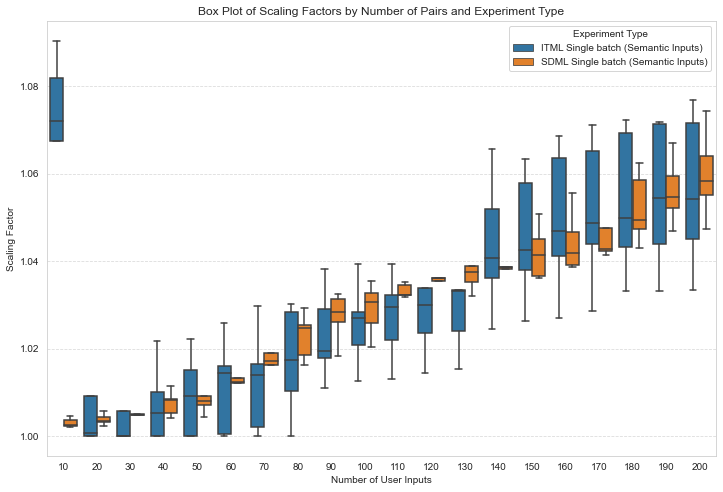

In [103]:
# Convert 'Num Pairs' to a categorical variable for better grouping in Seaborn
results['Num of Inputs'] = results['Num of Inputs'].astype(int)
results['Scaling Factor'] = pd.to_numeric(results['Scaling Factor'])

plt.figure(figsize=(12, 8))
sns.boxplot(
    data=results,
    x='Num of Inputs',
    y='Scaling Factor',
    hue='Experiment Type',  # Subgroups
    showfliers=False  # Hide outliers for clearer visualization
)

# Add labels and title
plt.xlabel('Number of User Inputs')
plt.ylabel('Scaling Factor')
plt.title('Box Plot of Scaling Factors by Number of Pairs and Experiment Type')
plt.legend(title='Experiment Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()